In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from models.CNN import CNN_128
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from utils.visual import accuracyV, trnV_loss , prf1V
import json
import os
import copy
import pandas as pd
from dataset.myjson import myjson
from dataset.emdata import emdata
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f'avaiable device : %s' % device)
# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)


folder = "resnet50_pre"
name = "resnet50_bs256_sz224_0001_real"

avaiable device : cuda:1


In [9]:
from models.VGG import vgg11_bn
from models.CNN import CNN_128,CNN_224

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model = CNN_224().to(device)
# model.load_state_dict(torch.load("CNN_224_bs256_0001.pth"))
# model.load_state_dict(torch.load('model.pth'))

lr = 0.01 # 바꿔봐야 하는 거 (하이퍼 파라미터)
epochs = 2 # 바꿔봐야 하는 거 (하이퍼 파라미터)

criterion = torch.nn.CrossEntropyLoss().to(device) # 고정
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=100, gamma=1)

trainloader, valloader = emdata(256,224) # 8:1:1
#1500x 1000 ~ 1480x1320 --> resize # 바꿔봐야 하는 거 (하이퍼 파라미터)
#def emdata(batch_size = 32, size = 128): size가 resize를 의미함
#CNN_128은 size = 128 이어야함, VGG는 전부 224 

In [16]:
# import torch

# 저장된 체크포인트 불러오기
checkpoint = torch.load(f'result/{name}/{folder}.pth')

# 모델 정의 및 상태 복원
# model = YourModel()
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
# 그래프 데이터 불러오기
accuracies = checkpoint['accuracies']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
lr = checkpoint['lr']

f1s = checkpoint['f1']
precisions = checkpoint['precision']
recalls = checkpoint['recalls']

c_f1s = checkpoint['c_f1s']
c_precisions = checkpoint['c_precisions']
c_recalls = checkpoint['c_recalls']




In [10]:
train_losses = [] # train loss 시각화 위한 리스트
val_losses = [] # val loss 시각화 위한 리스트
accuracies = []  # 에포크별 정확도를 저장할 리스트 초기화
lr = []

f1s = []
precisions = []
recalls = []

c_f1s = []
c_precisions = []
c_recalls = []

Training Start!


100%|██████████| 9/9 [00:25<00:00,  2.79s/it]
/home/KDT-admin/miniconda3/envs/seoik/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch:    1] Train Loss = 104.092668202, Val Loss = 1.814759254, val Accuracy = 25.33%,lr = 0.0100000


100%|██████████| 9/9 [00:23<00:00,  2.61s/it]


[Epoch:    2] Train Loss = 1.680151423, Val Loss = 1.542981982, val Accuracy = 25.33%,lr = 0.0100000
59.90110182762146
Finished Training


/home/KDT-admin/miniconda3/envs/seoik/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


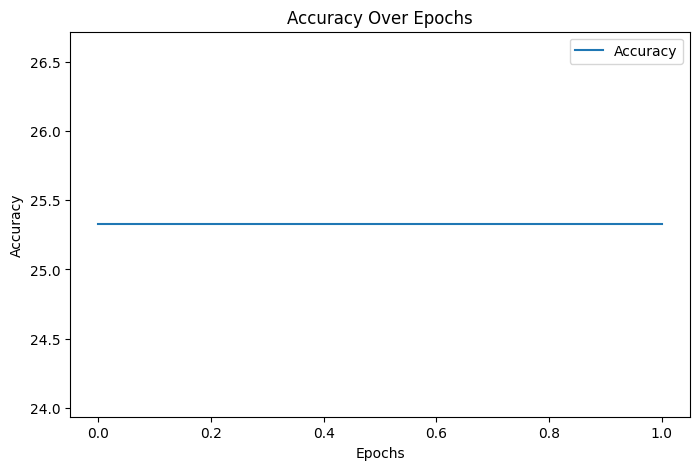

Accuracy graph saved successfully.
Train and validation loss graph saved successfully.


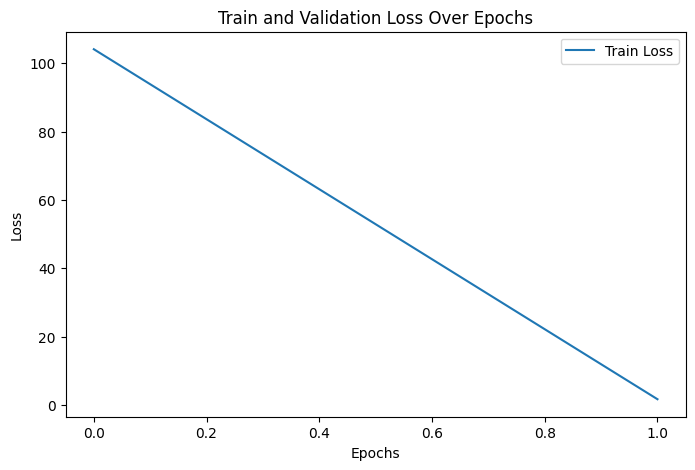

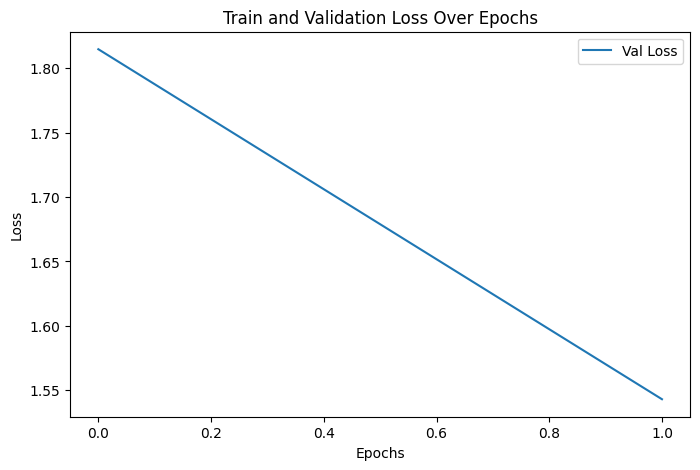

Train and validation loss graph saved successfully.
Precision graph saved successfully.


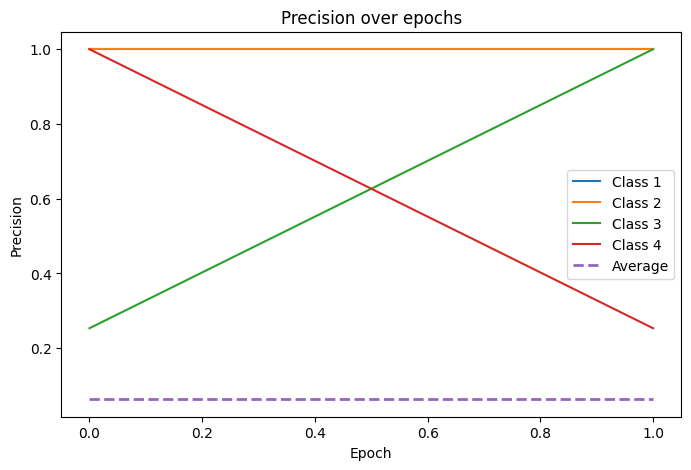

Recall graph saved successfully.


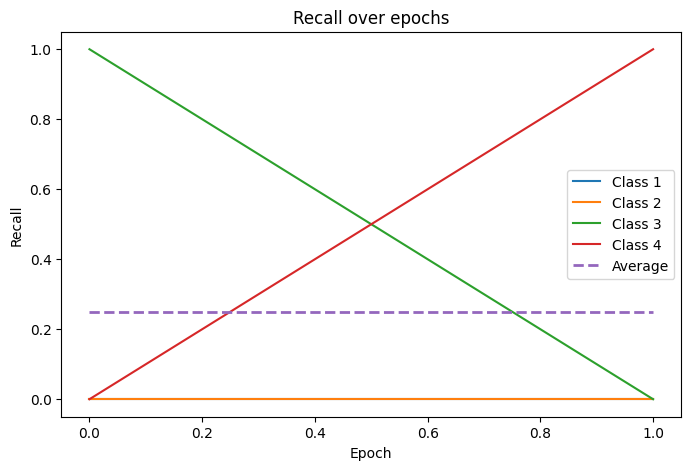

F1  graph saved successfully.


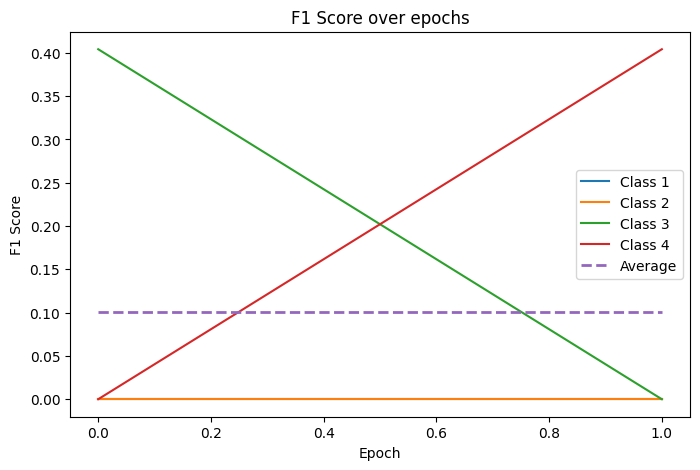

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

start_time = time.time()
print("Training Start!")

############################################
for epoch in range(epochs):  
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader)):  
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  
       
        running_loss += loss.item()
    
    scheduler.step()
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

######################################################
    # Evaluation on val set
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
#######################################################
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ############################################
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            #####################################
    # Calculate accuracy
    accuracy = 100 * correct / total
    accuracies.append(accuracy)  # 정확도를 리스트에 추가
    # Print and store test loss
    val_loss = running_loss / len(valloader)
    val_losses.append(val_loss)


    #######################################################
    precision = precision_score(all_labels, all_predictions , average=None,zero_division=1)
    recall = recall_score(all_labels, all_predictions , average=None,zero_division=1)
    f1 = f1_score(all_labels, all_predictions , average=None,zero_division=1)
    c_precisions.append(precision)
    c_recalls.append(recall)
    c_f1s.append(f1)
    ####################################average = None 각 클래스별로 구해서 배열로 넘겨줌
    precision = precision_score(all_labels, all_predictions , average='macro')
    recall = recall_score(all_labels, all_predictions , average='macro')
    f1 = f1_score(all_labels, all_predictions , average='macro')
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    ##########################################################average = macro 평균값으로 넘겨줌

    x = scheduler.get_last_lr()[0]
    lr.append(x)
    print('[Epoch: {:>4}] Train Loss = {:.9f}, Val Loss = {:.9f}, val Accuracy = {:.2f}%,lr = {:.7f}'.format(epoch + 1, train_loss, val_loss, accuracy,x))







##########################################################################
print(time.time()-start_time)
print('Finished Training')

accuracyV(accuracies , f"{folder}",f"{name}")
trnV_loss(train_losses,val_losses ,f"{folder}",f"{name}")

prf1V(f1s,precisions,recalls,c_f1s,c_precisions,c_recalls,f"{folder}",f"{name}")





In [ ]:

# 모델 및 그래프 데이터 저장
checkpoint = {
    'model_state_dict': model.state_dict(),
    'accuracies': accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'lr' : lr,
    'f1' : f1s ,
    'precision' : precisions,
    'recalls' : recalls,
    'c_f1s' : c_f1s,
    'c_precisions': c_precisions,
    'c_recalls' : c_recalls
    ,
}


# 저장할 경로 지정
checkpoint_path = f'result/{name}/{folder}.pth'

# 체크포인트 저장
torch.save(checkpoint, checkpoint_path)


In [ ]:
# torch.save(model.state_dict(), "CNN_224_bs256_0001.pth")

In [ ]:
# model = model = vgg11_bn().to(device)
# model.load_state_dict(torch.load("jaehyun_fin 0.00001.pth"))

In [ ]:
from matric.accuracy import acc
from utils.visual import Accuracy_CM_V
import matplotlib.pyplot as plt
from utils.dataframe import make_df
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'avaiable device : %s' % device)
model = model.to(device)
df, fig, accuracy , class_acc = Accuracy_CM_V(model , valloader , f"{folder}",f"{name}")


result_df = make_df(accuracy, class_acc ,df, f"{folder}",f"{name}")
result_df.head()